# Stage IV Galaxy Survey

This example simulates a galaxy catalogue from a Stage IV Space Satellite Galaxy Survey such as *Euclid* and *Roman* combining the [galaxies](../1-basic/density.ipynb) and [lensing](../1-basic/lensing.ipynb) examples with galaxy ellipticities and galaxy shears, as well as using some auxiliary functions.

The focus in this example is mock catalogue generation using auxiliary functions built for simulating Stage IV galaxy surveys.

## Setup

The setup is essentially the same as in the [cosmic shear](cosmic_shear.ipynb) example.

In addition, we also show how to use auxiliary functions to generate tomographic redshift distributions and visibility masks.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.ext.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

Set up the matter sector.

In [2]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

# linear window functions for shells
ws = glass.shells.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, ws)

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

Set up the lensing sector.

In [3]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

Set up the galaxies sector.

In [4]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 0.3

# true redshift distribution following a Smail distribution
z = np.arange(0.0, 3.0, 0.01)
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2.0, beta=1.5)
dndz *= n_arcmin2

# distribute dN/dz over the radial window functions
ngal = glass.shells.partition(z, dndz, ws)

# compute tomographic redshift bin edges with equal density
nbins = 10
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# constant bias parameter for all shells
bias = 1.2

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_e = 0.27

Make a visibility map typical of a space telescope survey, seeing both hemispheres, and low visibility in the galactic and ecliptic bands.

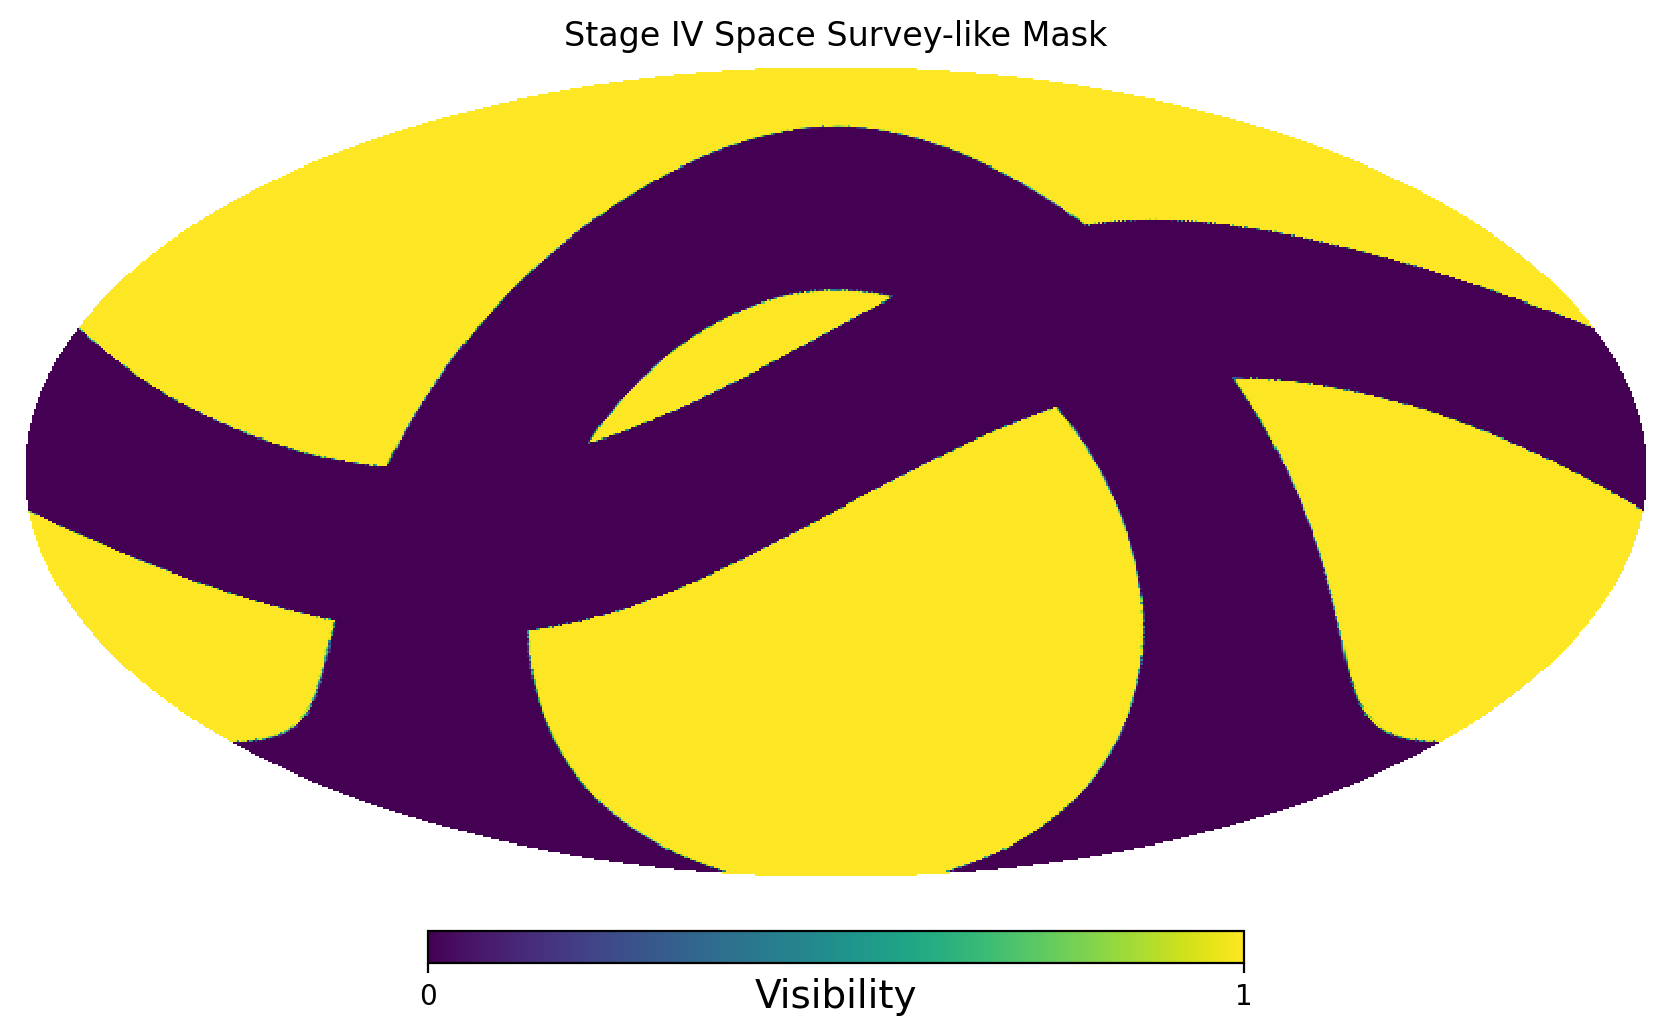

In [5]:
vis = glass.observations.vmap_galactic_ecliptic(nside)

# checking the mask:
hp.mollview(vis, title='Stage IV Space Survey-like Mask', unit='Visibility')
plt.show()

## Simulation

Simulate the galaxies with shears.
In each iteration, get the quantities of interest to build our mock catalogue.

In [6]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float),
                               ('Z_TRUE', float), ('PHZ', float), ('ZBIN', int),
                               ('G1', float), ('G2', float)])

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # generate galaxy positions from the matter density contrast
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal[i], delta_i, bias, vis):

        # generate random redshifts over the given shell
        gal_z = glass.galaxies.redshifts(gal_count, ws[i])

        # generator photometric redshifts using a Gaussian model
        gal_phz = glass.galaxies.gaussian_phz(gal_z, sigma_z0)

        # attach tomographic bin IDs to galaxies, based on photometric redshifts
        gal_zbin = np.digitize(gal_phz, np.unique(zbins)) - 1

        # generate galaxy ellipticities from the chosen distribution
        gal_eps = glass.shapes.ellipticity_intnorm(gal_count, sigma_e)

        # apply the shear fields to the ellipticities
        gal_she = glass.galaxies.galaxy_shear(gal_lon, gal_lat, gal_eps,
                                              kappa_i, gamm1_i, gamm2_i)

        # make a mini-catalogue for the new rows
        rows = np.empty(gal_count, dtype=catalogue.dtype)
        rows['RA'] = gal_lon
        rows['DEC'] = gal_lat
        rows['Z_TRUE'] = gal_z
        rows['PHZ'] = gal_phz
        rows['ZBIN'] = gal_zbin
        rows['G1'] = gal_she.real
        rows['G2'] = gal_she.imag

        # add the new rows to the catalogue
        catalogue = np.append(catalogue, rows)

print(f'Total number of galaxies sampled: {len(catalogue):,}')

Total number of galaxies sampled: 22,280,746


## Catalogue checks

Here we can perform some simple checks at the catalogue level to see how our simulation performed.

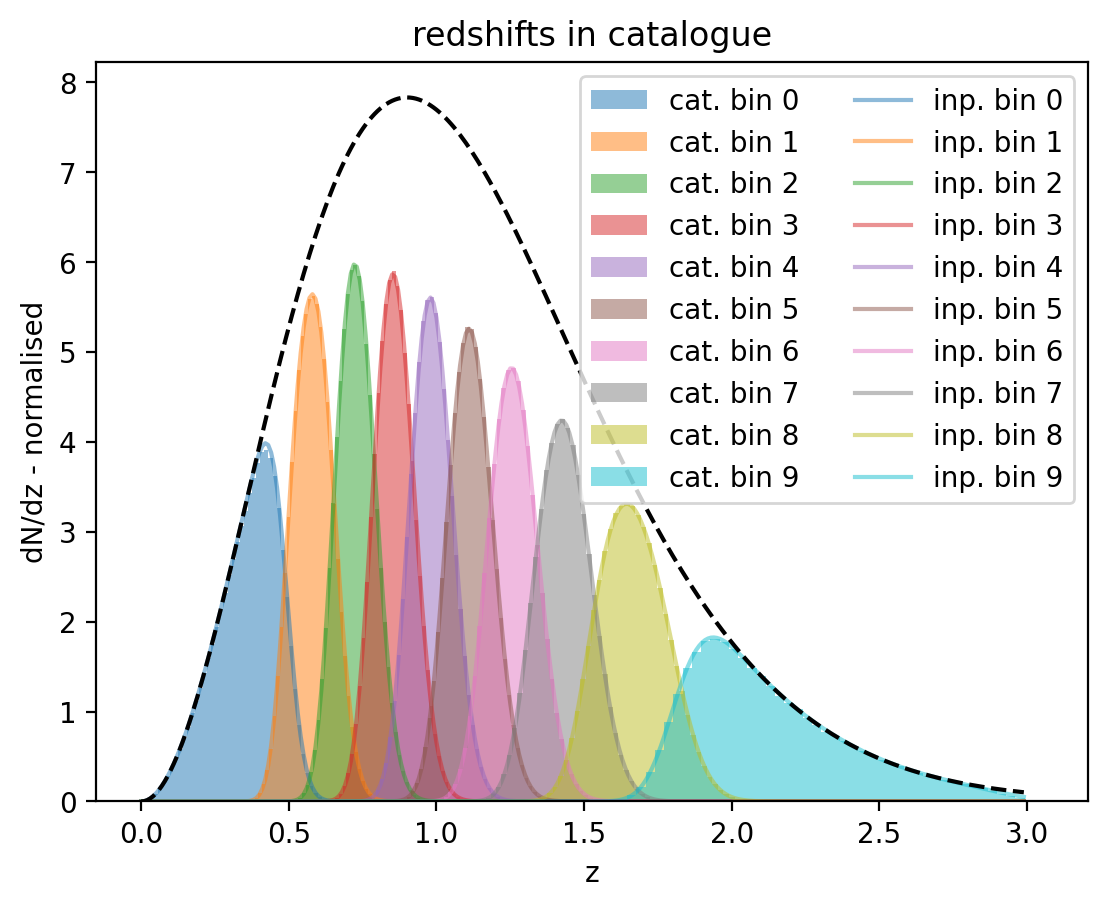

In [7]:
# split dndz using the same Gaussian error model assumed in the sampling
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zbins)

# redshift distribution of tomographic bins & input distributions
plt.figure()
plt.title('redshifts in catalogue')
plt.ylabel('dN/dz - normalised')
plt.xlabel('z')
for i in range(nbins):
    in_bin = (catalogue['ZBIN'] == i)
    plt.hist(catalogue['Z_TRUE'][in_bin], histtype='stepfilled', edgecolor='none', alpha=0.5, bins=50, density=1, label=f'cat. bin {i}')
for i in range(nbins):
    plt.plot(z, (tomo_nz[i]/n_arcmin2)*nbins, alpha=0.5, label=f'inp. bin {i}')
plt.plot(z, dndz/n_arcmin2*nbins, ls='--', c='k')
plt.legend(ncol=2)
plt.show()